In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

In [2]:
H = 100
W = 100
h = H-1
w = W-1

n_min = 2
n_max = 6

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.65456202 0.75       0.1946999  0.24      ]
 [0.42831071 0.25       0.19841032 0.42627298]]
[0. 0.]


In [3]:
anchor_boxes = np.array([
    [0.5,0.5],
    [0.5,0.25],
    [0.25,0.5],
    [0.25,0.25],
    [0.25,0.125],
    [0.125,0.25],
    [0.125,0.125]
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

W0808 11:46:32.385894 139731263833856 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


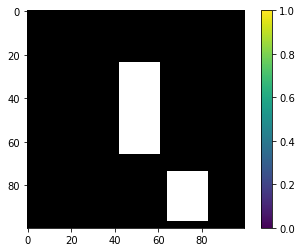

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain = 1000
lr     = 0.01

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,3], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K])

backbone = net.Backbone(input_channels=3, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=30, hidden_size=256)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.nn.sigmoid_cross_entropy(labels=y_labels_tf, 
                                         logits=list_obj_logits)
loss_box   = list_obj*(tf.square(list_box - y_box_tf))

W0808 11:46:33.059242 139731263833856 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0808 11:46:33.061275 139731263833856 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0808 11:46:33.062340 139731263833856 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Tensor("Reshape:0", shape=(1, 100, 100, 7, 4), dtype=float32)
Tensor("object_conv/Sigmoid:0", shape=(1, 100, 100, 7), dtype=float32)
Tensor("Reshape_1:0", shape=(70000, 4), dtype=float32)
Tensor("Reshape_2:0", shape=(70000,), dtype=float32)


In [ ]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    #model.train(x,gt_t,gt_labels,gt_weights)